In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
from pathlib import Path

# Set paths
from scaling_up_framework_functions import (
    SpatialScale,
    plot_spatial_hierarchy,
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# =============================================================================
# TEST FILE PATHS
# =============================================================================
SPATIAL_PATH = Path("./test/")
DATA_PATH = Path("./test/")
OUTPUT_PATH = Path("./test/output/")

# Test functional group rules
GROUP_RULES = {
    "BaseUnits": {"vegetation": ["Forest", "Grassland"], "water": ["Wetland"]}
}

# =============================================================================
# PROJECTION FOR SPATIAL DATA
# =============================================================================
DEFAULT_CRS = "EPSG:4326"

# Load in the spatial data

The base scale is the smallest atomic unit that is to be aggregated up to larger scales

The aggregation scales are those larger scales - here representing larger regions, and the whole river basin that encompasses all base-scale units.

Loading BaseScale data from base_units.shp...
   Requested: ['Area_Ha', 'HabitatTyp', 'UID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['UID', 'HabitatTyp', 'Area_Ha', 'NDVI']
   Detected geometry type: polygon (4 features)


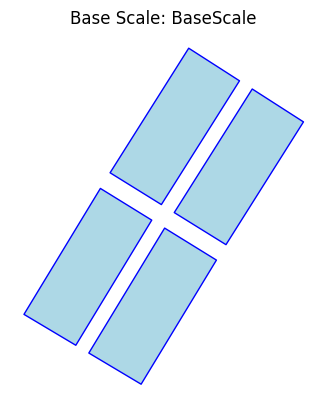

In [57]:
# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Load the base spatial scale
base_scale = SpatialScale(
    name="BaseScale",
    source=SPATIAL_PATH / "base_units.shp",
    unique_id_field="UID",
    weighting_field="Area_Ha",
    #metric_fields="NDVI",  
    measure_multiplier=None,
    type_field="HabitatTyp",
    is_base_scale=True,
    #default_crs="EPSG:4326"
)

base_scale.plot()

Loading Regions data from regions.shp...
   Requested: ['RegionID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['RegionID', 'RegionName']
   Detected geometry type: polygon (2 features)
Loading Basin data from basin.shp...
   Requested: ['BasinID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['BasinID', 'BasinName']
   Detected geometry type: polygon (1 features)


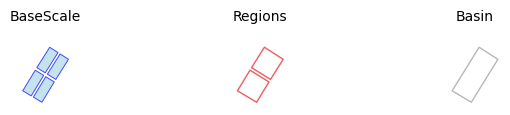

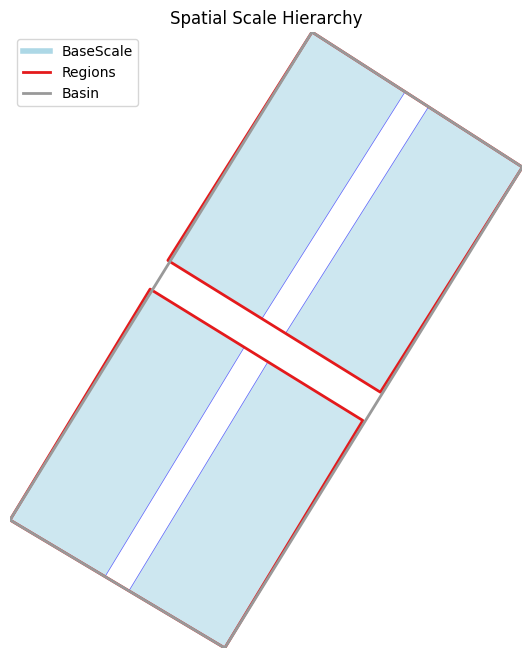

In [58]:
# Create aggregation scale objects

region_scale = SpatialScale(
    "Regions",
    source = SPATIAL_PATH / "regions.shp",
    unique_id_field="RegionID",
)

basin_scale = SpatialScale(
    "Basin",
    source = SPATIAL_PATH / "basin.shp",
    unique_id_field="BasinID",
)


# the first item in the list is the base scale
plot_spatial_hierarchy(base_scale, region_scale, basin_scale)

# Optional - join additional data loaded from a CSV file

Requires one column matches the base-scale `unique_id_field` so the data can be joined to the basal features.
If the data is in wide-form tabular format (wide-form) each row should be a 1:1 match with a unique_id in the base-scale data set. Unmatched rows will be dropped.
If he data is long-form it will be pivoted to wide-form and multiple columns of data will be joined to the base-scale data


join_data

Load external tabular data and join it to the SpatialScale's data.

Supports:

1. Direct join if data is in wide format (one row per unique_id).
2. Pivoting long data (key-value) into wide before join.

options:
   - data_path: Path to the CSV or tabular data file.
   - unique_id_field: Column in the CSV matching source unique ID. If None, defaults to self.unique_id.
   - pivot_row_id: If pivoting, list of columns to use as index.
   - pivot_columns: If pivoting, column name whose values become new columns.
   - pivot_values: If pivoting, column name containing values to fill.
   - how: Type of join to perform (default "inner").  Keeps only matching data and discards items with no data.




In [60]:

# Join to base scale
base_scale.join_data(
    data_path=DATA_PATH / "test_cover_data.csv",
    pivot_row_id=["UID"],
    pivot_columns="year",
    pivot_values="cover",
)


print (base_scale.data.drop(columns=['geometry']).head(10))

No metric fields specified. Inferred: ['2020', '2021', '2022']
Joined external data from test\test_cover_data.csv on 'UID'
    UID HabitatTyp  Area_Ha  NDVI  2020  2021  2022  2020_external  \
0  B001     Forest    200.0  0.80  0.80  0.82  0.78           0.80   
1  B002    Wetland    200.0  0.60  0.60  0.58  0.62           0.60   
2  B003     Forest    200.0  0.75  0.75  0.77  0.73           0.75   
3  B004  Grassland    200.0  0.50  0.50  0.52  0.48           0.50   

   2021_external  2022_external  
0           0.82           0.78  
1           0.58           0.62  
2           0.77           0.73  
3           0.52           0.48  


⚖️ 4. Perform Geometry-Weighted Aggregation to Regions

In [61]:

# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="2020-2022_weighted_mean3s",
)



Performing spatial join: BaseScale to Regions using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'HabitatTyp' into new groups '_grp_' using supplied reclass map...
Aggregating by ['RegionID', '_grp_'] using 'weighted_mean'
Stored result in Regions.results['2020-2022_weighted_mean3s']


⚖️ 4. Perform Attribute-Weighted Aggregation to Regions

In [63]:

# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    weighting_field="NDVI",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="cover_NDVI_weighted_annual_mean",
)

Using 'NDVI' for 'NDVI_weighted' aggregation
Using cached spatial join: Regions_intersects
Reclassifying 'HabitatTyp' into new groups '_grp_' using supplied reclass map...
Aggregating by ['RegionID', '_grp_'] using 'weighted_mean'
Stored result in Regions.results['cover_NDVI_weighted_annual_mean']


In [64]:
region_scale.save_results("list")

Available results:
  2020-2022_weighted_mean3s      -          3 rows ['RegionID', '_grp_', '2020_Areawm', '2021_Areawm', '2022_Areawm']
  cover_NDVI_weighted_annual_mean -          3 rows ['RegionID', '_grp_', '2020_NDVIwm', '2021_NDVIwm', '2022_NDVIwm']


📊 5. Frequency-Weighted Aggregation to Basin

In [65]:
# Geometry-weighted mean NDVI aggregated from base to regions
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="frequency_weighted",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="NDVI_frequency_weighted_mean",
)

Performing spatial join: BaseScale to Basin using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'HabitatTyp' into new groups '_grp_' using supplied reclass map...
Aggregating by ['BasinID', '_grp_'] using 'frequency_weighted'
Stored result in Basin.results['NDVI_frequency_weighted_mean']


In [66]:
basin_scale.save_results("list")

Available results:
  NDVI_frequency_weighted_mean   -          2 rows ['BasinID', '_grp_', '2020_frqwm', '2021_frqwm', '2022_frqwm']


💾 7. Save Outputs (GeoPackage and CSV)

In [67]:
region_scale.save_results(OUTPUT_PATH, file_types=["csv", "gpkg"])

basin_scale.save_results(OUTPUT_PATH, file_types=["csv", "gpkg"])

Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Regions_cover_NDVI_weighted_annual_mean.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Regions_cover_NDVI_weighted_annual_mean.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.csv
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.gpkg


✅ 8. Review Outputs